In [311]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [312]:
import numpy as np
import pandas as pd

In [313]:
import datetime as dt
from datetime import timedelta

In [314]:
import sys, inspect

# Reflect Tables into SQLAlchemy ORM

In [315]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [316]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [317]:
# Reflect Database into ORM classes
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [318]:
# Map Measurement and Station classes
measurement = Base.classes.measurement
station = Base.classes.station

In [319]:
# Create a session
session = Session(engine)

In [320]:
# Inspect Engine
inspector = inspect(engine)

In [321]:
# Get a list of column names and types
measurement_columns = inspector.get_columns('measurement')
for colm in measurement_columns:
    print(colm['name'], colm['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [322]:
# View Measurement data
engine.execute('SELECT * FROM measurement LIMIT 3').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0)]

# Exploratory Climate Analysis

## Precipitation Analysis

In [336]:
# Get the Latest Date
latest_date = session.query(func.max(measurement.date)).first()

# Convert Day, Month and Year to interger and assign to variant
ld_year = int(latest_date[0][:4])
ld_mth = int(latest_date[0][5:7])
ld_day = int(latest_date[0][8:10])

# Pass Variants through dt.date func and calculate 'Start' and 'End' dates
rpt_end_date = dt.date(ld_year, ld_mth, ld_day)
delta = dt.timedelta(days=365)
rpt_start_date = rpt_end_date - delta
print(rpt_start_date)

2016-08-23


In [371]:
# Query last 12 months and assign results into a Pandas DataFrame sorted by date as index
twlv_months = session.query(measurement.date, measurement.prcp)\
                    .filter(measurement.date >= rpt_start_date)\
                    .all()

twlv_months =  pd.DataFrame(twlv_months).fillna(0).set_index('date').sort_index()

print(f'Twelve Month Period: {twlv_months.index.min()} to {twlv_months.index.max()}')

Twelve Month Period: 2016-08-23 to 2017-08-23


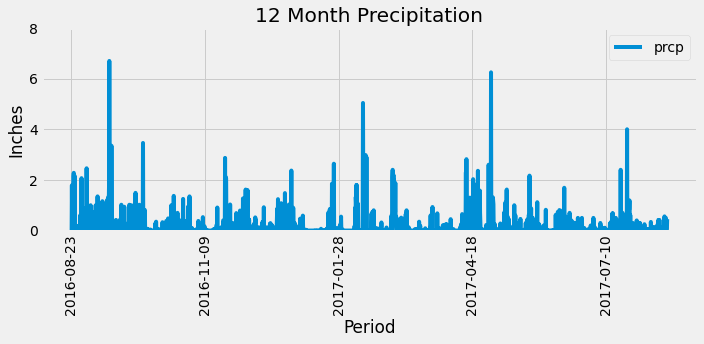

In [357]:
# Plot results with DataFrame plot
twlv_months.plot(figsize=(10,5),ylim=(0,8))
plt.xticks(rotation=90)
plt.title('12 Month Precipitation')
plt.xlabel('Period')
plt.ylabel('Inches')

plt.tight_layout()
plt.savefig("Images/12_Month_Precipitation.png")
plt.show()

In [358]:
# Summary statistics for the precipitation data
twlv_months.describe().rename(columns={'prcp': 'Precipitation'})

,Precipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


## Station Analysis

In [340]:
station_columns = inspector.get_columns('station')
for cols in station_columns:
    print(cols['name'], cols['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [341]:
# Calculate the total number of stations
station_data = session.query(station.station).all()
print(f'Total Number of Stations: {pd.Series(station_data).value_counts().sum()}')
print(pd.Series(station_data).value_counts())

Total Number of Stations: 9
(USC00513117,)    1
(USC00511918,)    1
(USC00517948,)    1
(USC00514830,)    1
(USC00519523,)    1
(USC00519281,)    1
(USC00519397,)    1
(USC00516128,)    1
(USC00518838,)    1
dtype: int64


In [375]:
selected_cols = [
    measurement.date,
    measurement.prcp,
    measurement.tobs,
    station.station,
    station.name,
    station.latitude,
    station.longitude,
    station.elevation
]

station_observe = session.query(*selected_cols).filter(measurement.station == station.station).all()
station_observe = pd.DataFrame(station_observe).fillna(0)

In [376]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = pd.Series(station_observe['station'].value_counts())
active_stations

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64

In [344]:
# Calculate the lowest temperature recorded, highest temperature recorded, and
# average temperature of the most active station?
# Summary Status

station_low = []
most_active = active_stations.head(1).index.item()
no_stations = pd.Series(station_observe['station'].unique())

for s in no_stations:
    station_ltemp = station_observe.loc[station_observe['station'] == s]
    stat_low = {
        'Station': s,
        'Lowest Temp' : station_ltemp['tobs'].min(),
        'Highest Temp' : station_ltemp['tobs'].max(),
        'Average Temp' : station_ltemp['tobs'].mean(),
        'Observations' :  station_ltemp['tobs'].count()
    }
    station_low.append(stat_low)
    
station_low_df = pd.DataFrame(station_low)
station_low_df.fillna(value=0, inplace=True)
station_low_df.set_index('Station', inplace=True)
station_low_df.sort_values('Observations', ascending=False)
print("Most Active Station:")
station_low_df.loc[[most_active]]

Most Active Station:


,Lowest Temp,Highest Temp,Average Temp,Observations
Station,,,,
USC00519281,54.0,85.0,71.663781,2772


In [345]:
# Query last 12 months and assign results into a Pandas DataFrame sorted by date as index
act_station_twlv_months = session.query(measurement.station, measurement.date, measurement.tobs)\
                            .filter(measurement.date >= rpt_start_date, measurement.station == most_active)\
                            .all()

act_station_twlv_months =  pd.DataFrame(act_station_twlv_months).fillna(0)

act_station_twlv_months.head(3)

,station,date,tobs
0,USC00519281,2016-08-23,77.0
1,USC00519281,2016-08-24,77.0
2,USC00519281,2016-08-25,80.0


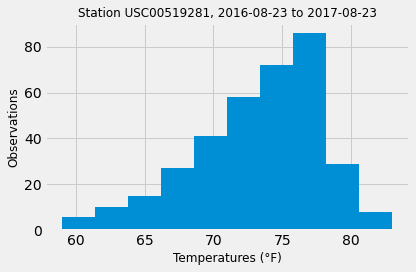

In [346]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
act_station_twlv_months.hist('tobs')
plt.title(f'Station {most_active}, {rpt_start_date} to {rpt_end_date}', fontsize='12')
plt.xlabel('Temperatures (°F)', fontsize='12')
plt.ylabel('Observations', fontsize='12')

plt.tight_layout()
plt.savefig(f"Images/Station_{most_active}.png")
plt.show()

## Bonus Challenge Assignment

In [347]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-02-28', '2017-03-05'))

[(64.0, 72.02777777777777, 78.0)]


In [348]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

trip_temps = calc_temps('2016-02-28', '2016-03-05') 
print(trip_temps)

[(62.0, 69.88636363636364, 80.0)]


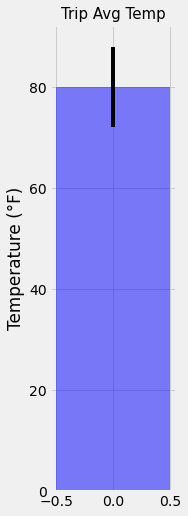

In [349]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = trip_temps[0][0]
tmax = trip_temps[0][1]
tavg = trip_temps[0][2]

y_err = tmax-tmin

plt.figure(figsize=(2,8))
plt.bar(0, tavg, yerr=y_err, align="center", width=1, color="b", alpha=0.5)
plt.ylim=(0,50)
plt.ylabel('Temperature (°F)')
plt.title('Trip Avg Temp', fontsize=15)
plt.savefig("Images/Avg_Trip_Temperature.png")
plt.show()

In [350]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-02-28'
end_date = '2017-03-05'

selection = [station.station, station.name, station.latitude, 
       station.longitude, station.elevation, func.sum(measurement.prcp)]

travel_precp = session.query(*selection).\
    filter(measurement.station == station.station).\
    filter(measurement.date >= start_date).\
    filter(measurement.date <= end_date).\
    group_by(station.name).order_by(func.sum(measurement.prcp).desc()).all()

for st, nam, lat, lng, elv, prcp in travel_precp:
    print(st, nam, lat, lng, elv, round(prcp,2))

USC00519281 WAIHEE 837.5, HI US 21.45167 -157.84888999999998 32.9 4.72
USC00513117 KANEOHE 838.1, HI US 21.4234 -157.8015 14.6 4.45
USC00516128 MANOA LYON ARBO 785.2, HI US 21.3331 -157.8025 152.4 4.07
USC00517948 PEARL CITY, HI US 21.3934 -157.9751 11.9 2.98
USC00519397 WAIKIKI 717.2, HI US 21.2716 -157.8168 3.0 2.74
USC00519523 WAIMANALO EXPERIMENTAL FARM, HI US 21.33556 -157.71139 19.5 2.32
USC00514830 KUALOA RANCH HEADQUARTERS 886.9, HI US 21.5213 -157.8374 7.0 1.16


In [351]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [352]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
cal_normal = []
normals = []

# Set the start and end date of the trip
start_date = '2017-02-28'
end_date = '2017-03-05'

# Use the start and end date to create a range of dates
date_range = pd.date_range(start=start_date, end=end_date)

# Stip off the year and save a list of %m-%d strings
mth_day_lst = date_range.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
for date in mth_day_lst:
    cal_normal.append(daily_normals(date))

# Flatten The List
for day in cal_normal:
    for cal in day:
        normals.append(cal)
    
normals

[(65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [353]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_norms_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
daily_norms_df['date'] = date_range
daily_norms_df.set_index(['date'], inplace=True)
daily_norms_df.head()

,tmin,tavg,tmax
date,,,
2017-02-28,65.0,70.655172,80.0
2017-03-01,64.0,70.032787,76.0
2017-03-02,61.0,70.366667,78.0
2017-03-03,60.0,70.068966,78.0
2017-03-04,57.0,69.272727,77.0


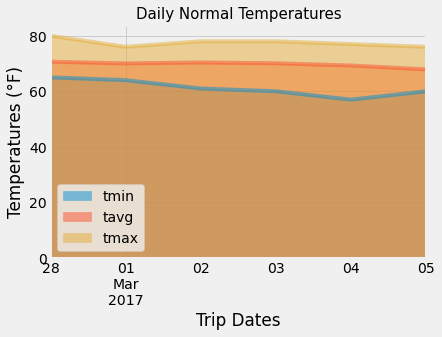

In [354]:
# Plot the daily normals as an area plot with `stacked=False`
daily_norms_df.plot(kind='area', stacked=False)
plt.title('Daily Normal Temperatures', fontsize=15)
plt.ylabel('Temperatures (°F)')
plt.xlabel('Trip Dates')
plt.savefig("Images/Daily_Normals.png")
plt.show()